**In this notebook we fit a PCA model (on healthy data only) which we save and later re-use as a dimensionality reduction method before the autoencoder**

In [1]:
from preprocessing import *
import joblib

**FX10 camera**

In [2]:
save_path = 'models/pca'

In [3]:
# Assemble dataset for training PCA - should include (equal amount of) data from all classes
CAMERA = 'FX10'
IMG_DIR = '../Strawberries/PotsprocessedData/cropped_hdf5'

# Healthy leaves
DATES = ['07SEPT2023', '08SEPT2023', '09SEPT2023', '10SEPT2023', '11SEPT2023', '12SEPT2023',
         '13SEPT2023', '14SEPT2023', '15SEPT2023', '18SEPT2023', '19SEPT2023']
TRAYS = ['3D', '4C', '4D', '2D']    # Some files from the FX17 camera are mistakenly named in 2D instead of 4D
healthy_FX10 = filter_filenames(folder_path=IMG_DIR, camera_id=CAMERA, date_stamps=DATES, tray_ids=TRAYS)

# Number of samples
print(f'Healthy: {len(healthy_FX10)}')

Healthy: 321


First conduct PCA on a large number of components (now 30) and then select a more appropriate number of PCs

In [4]:
# Preprocess data
X = load_and_flatten_hsi(img_paths=healthy_FX10, mask_dir='../Strawberries/PotsprocessedData/cropped_masks',
                         apply_mask=True, individual_normalize=True, mask_method=0, min_wavelength=430)
print(f"Data shape before PCA: {X.shape}")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=30)    # Keep 30 components
X_pca = pca.fit_transform(X_scaled)

# Print results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("---------------------------------")
print(f"Number of components chosen: {pca.n_components_}")
print(f"Explained variance ratio: {cumulative_variance_ratio[-1]:.4f}")
print(f"Data shape after PCA: {X_pca.shape}")

# Save PCA model and scaler - Not now!
# joblib.dump(pca, os.path.join(save_path, 'first_pca_model.joblib'))
# joblib.dump(scaler, os.path.join(save_path, 'first_scaler.joblib'))

Data shape before PCA: (20565957, 211)
---------------------------------
Number of components chosen: 30
Explained variance ratio: 0.9968
Data shape after PCA: (20565957, 30)


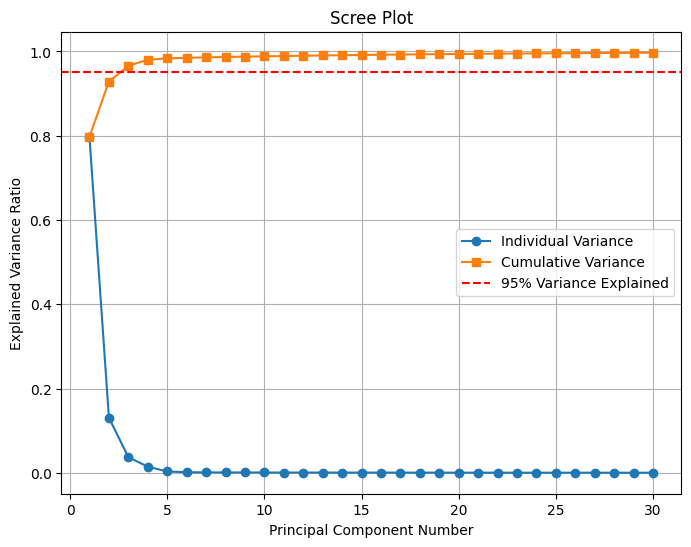

In [5]:
# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='s', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

Based on scree plot, there's an elbow at around 3/4/5 PCs. To help decide how many PCs to choose (which PCs doesn't only capture noise), we look at PC score images.

In [6]:
# Sample a random leaf for visualization
sample_healthy = '../Strawberries/PotsprocessedData/cropped_hdf5/FX10_07SEPT2023_4D2_0.hdf5'

sample_healthy, wlens = LoadHSI(sample_healthy, return_wlens=True)
sample_healthy, _ = preprocess(sample_healthy, wlens, min_wavelength=430, normalize=True)

# Data in PCA space
sample_healthy_pca = hsi_transform_to_pca_space(sample_healthy, pca, scaler, mask_np=None)

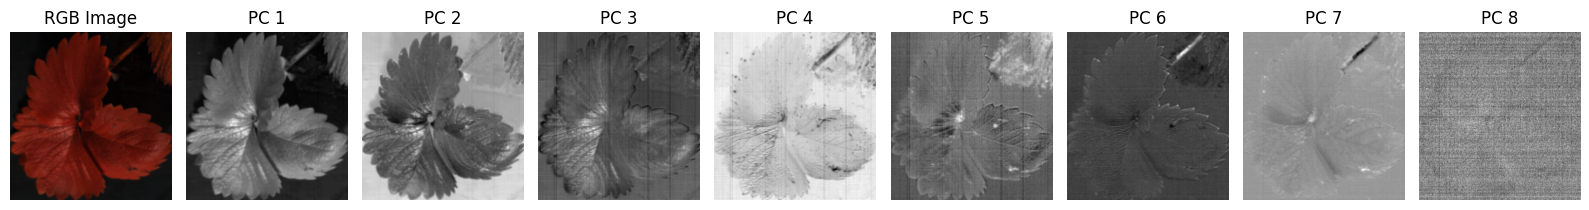

In [7]:
# Define the sample
samples = {
    "Healthy": sample_healthy
}

# Convert to PCA space
samples_pca = {label: hsi_transform_to_pca_space(hsi, pca, scaler) for label, hsi in samples.items()}

# Get the bands for false RGB
RGB_wlens = (685, 550, 450)
RGB_bands = np.argmin(np.abs(np.array(wlens)[:, np.newaxis] - RGB_wlens), axis=0)

# Extract RGB image
rgb_image = sample_healthy[RGB_bands].transpose((1,2,0))

# Number of PCs to visualize
n_pcs = 8

# Create figure with a single row layout
fig, axes = plt.subplots(1, n_pcs + 1, figsize=(16, 4))

# Plot RGB image (first column)
axes[0].imshow(rgb_image)
axes[0].set_title("RGB Image", fontsize=12)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_frame_on(False)

# Plot PC images (remaining columns)
for pc_idx in range(n_pcs):
    ax = axes[pc_idx + 1]
    pc_image = samples_pca["Healthy"][pc_idx]
    
    ax.imshow(pc_image, cmap="gray")
    ax.set_title(f"PC {pc_idx+1}", fontsize=12)
    
    # Remove tick marks, frame
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

plt.tight_layout()
plt.show()


It seems like even though there's not much added variance for PC4/5/6/7, PCs start to captur noise from PC8, so keeping PC6 can still be justifiable.

So we will keep 7 PCs. Note that seemingly PC7 is also close to capturing noise, whreas in pca_bandselect.ipynb PC7 still resembled the leaf better, which makes sense since now we only fit on healthy images which has less variability than if we were to use healthy-and unhealthy images, so there's less variability left for PC7 and later PCs so it starts capturing noise earlier when trained with healthy data only.

In [9]:
# Preprocess data
X = load_and_flatten_hsi(img_paths=healthy_FX10, mask_dir='../Strawberries/PotsprocessedData/cropped_masks',
                         apply_mask=True, individual_normalize=True, mask_method=0, min_wavelength=430)
print(f"Data shape before PCA: {X.shape}")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=7)    # Keep 7 components
X_pca = pca.fit_transform(X_scaled)

# Print results
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("---------------------------------")
print(f"Number of components chosen: {pca.n_components_}")
print(f"Explained variance ratio: {cumulative_variance_ratio[-1]:.4f}")
print(f"Data shape after PCA: {X_pca.shape}")

# Save PCA model and scaler
joblib.dump(pca, os.path.join(save_path, 'pca_model_healthy.joblib'))
joblib.dump(scaler, os.path.join(save_path, 'scaler_healthy.joblib'))

Data shape before PCA: (20565957, 211)
---------------------------------
Number of components chosen: 7
Explained variance ratio: 0.9858
Data shape after PCA: (20565957, 7)


['models/pca/scaler_healthy.joblib']

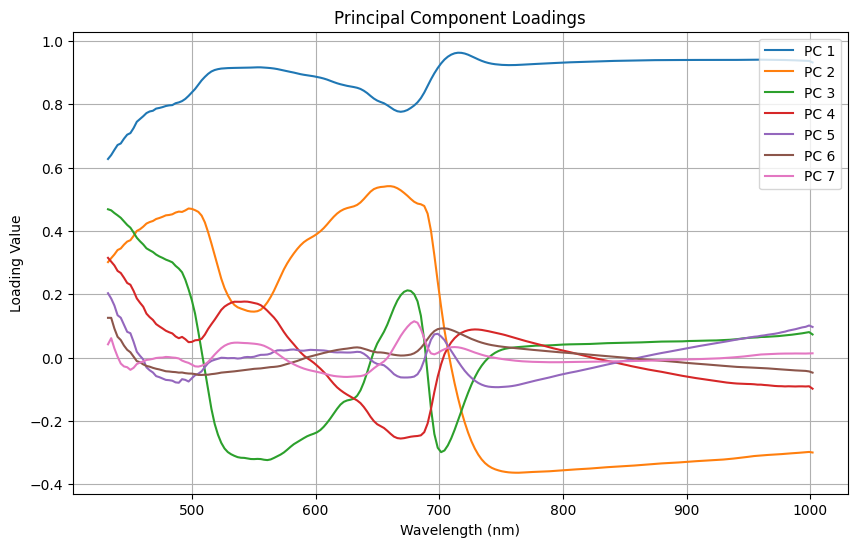

In [10]:
# Compute loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Load an example HSI - although we only need the wlens
hsi_np, wlens = LoadHSI('../Strawberries/PotsprocessedData/cropped_hdf5/FX10_07SEPT2023_3C2_0.hdf5', return_wlens=True)
hsi_np, wlens = preprocess(hsi_np, wlens, min_wavelength=430)

# Plot PC loadings
plt.figure(figsize=(10, 6))
for i in range(pca.n_components_):
    plt.plot(wlens, loadings[:, i], label=f'PC {i+1}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Loading Value')
plt.title('Principal Component Loadings')
plt.legend()
plt.grid()
plt.show()